In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2

In [2]:
path ='C:/Users/sdf80/Desktop/fruit_dataset/Normal/'

filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    label.append(file.split('.')[0])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img

datalist.head()

100%|██████████████████████████████████████████████████████████████████████████| 1122/1122 [00:00<00:00, 374533.15it/s]


,label,img
0,Bad,Bad.1.jpg
1,Bad,Bad.10.jpg
2,Bad,Bad.100.jpg
3,Bad,Bad.101.jpg
4,Bad,Bad.102.jpg


No handles with labels found to put in legend.


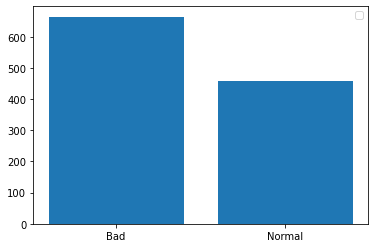

In [3]:
catnum = 0
dognum = 0

for i in datalist['label']:
    if i == 'Bad':
        catnum += 1
    if i == 'Normal':
        dognum += 1
        
plt.bar([1,2],[catnum, dognum],tick_label=['Bad','Normal'])
plt.legend()

In [4]:
def preprocessing(path) :
    X = []
    Y = []
    class_label = []
    class_num = 2
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'Bad': 
            X.append(img) 
            Y.append(0) 
        else : 
            X.append(img) 
            Y.append(1)

    tmpx = np.array(X) 

    Y = np.array([[i] for i in Y]) 
    enc = OneHotEncoder(categories='auto') 
    enc.fit(Y) 
    tmpy = enc.transform(Y).toarray() 

    del X 
    del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return tmpx , tmpy , class_label , class_num


tmpx, tmpy, class_label, class_num = preprocessing(path) 
#파일이름이 담긴 배열 
print(tmpx.shape, tmpy.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1122/1122 [00:02<00:00, 382.21it/s]

(1122, 160, 160, 3) (1122, 2)


In [5]:
img = cv2.imread(path+datalist['img'][1])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

array([1., 0.])

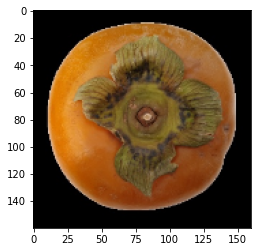

In [6]:
plt.imshow(tmpx[40])
tmpy[40]

In [7]:
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(tmpx,tmpy, test_size = 0.2,random_state = 1) 
del tmpx 
del tmpy #RAM메모리 절약을 위해 사용하지 않는 변수 삭제 

print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(897, 160, 160, 3) (225, 160, 160, 3) (897, 2) (225, 2)


In [8]:
nb_train_samples = len(X_train) 
nb_validation_samples = len(X_val) 
batch_size = 16 
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

val_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 

train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [9]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(160,160, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(16,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 158, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 79, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 77, 77, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 16)        0

In [10]:
learning_rate = 0.0005


model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
56/56 [==============================] - 23s 411ms/step - loss: 0.9061 - accuracy: 0.6107 - val_loss: 3.1860 - val_accuracy: 0.6250
Epoch 2/30
56/56 [==============================] - 23s 402ms/step - loss: 0.7076 - accuracy: 0.6663 - val_loss: 5.5213 - val_accuracy: 0.6295
Epoch 3/30
56/56 [==============================] - 23s 404ms/step - loss: 0.6569 - accuracy: 0.6890 - val_loss: 6.7053 - val_accuracy: 0.6295
Epoch 4/30
56/56 [==============================] - 23s 410ms/step - loss: 0.6266 - accuracy: 0.7121 - val_loss: 7.3081 - val_accuracy: 0.6205
Epoch 5/30
56/56 [==============================] - 23s 414ms/step - loss: 0.6182 - accuracy: 0.7083 - val_loss: 8.1345 - val_accuracy: 0.6920
Epoch 6/30
56/56 [==============================] - 23s 410ms/step - loss: 0.6091 - accuracy: 0.6822 - val_loss: 5.7096 - val_accuracy: 0.6964
Epoch 7/30
56/56 [==============================] - 23s 405ms/step

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

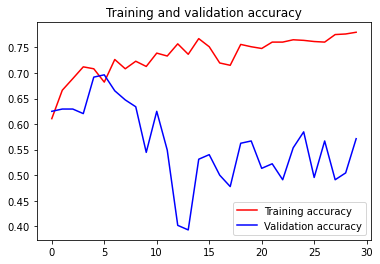

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [13]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop

In [14]:
pre_trained_model = InceptionV3(input_shape=(160, 160, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 79, 79, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [15]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

model2 = Model(pre_trained_model.input, x)

model2.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

last layer output shape:  (None, 8, 8, 768)


In [16]:
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Epoch 1/30
56/56 [==============================] - 147s 3s/step - loss: 6.1334 - accuracy: 0.5289 - val_loss: 0.6770 - val_accuracy: 0.6295
Epoch 2/30
56/56 [==============================] - 148s 3s/step - loss: 0.9355 - accuracy: 0.5982 - val_loss: 0.7074 - val_accuracy: 0.3705
Epoch 3/30
56/56 [==============================] - 147s 3s/step - loss: 0.6767 - accuracy: 0.6708 - val_loss: 0.6914 - val_accuracy: 0.6339
Epoch 4/30
56/56 [==============================] - 147s 3s/step - loss: 0.6797 - accuracy: 0.6595 - val_loss: 4.5877 - val_accuracy: 0.3527
Epoch 5/30
56/56 [==============================] - 147s 3s/step - loss: 0.6234 - accuracy: 0.6879 - val_loss: 122.6869 - val_accuracy: 0.3750
Epoch 6/30
56/56 [==============================] - 149s 3s/step - loss: 0.5890 - accuracy: 0.7094 - val_loss: 1.7315 - val_accuracy: 0.6339
Epoch 7/30
56/56 [==============================] - 147s 3s/step - loss: 0.5522 - accuracy: 0.7321 - val_loss: 23.1471 - val_accuracy: 0.3527
Epoch 8/30

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

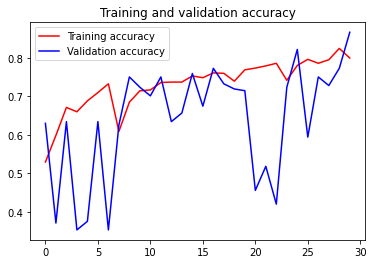

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [21]:
y_hat = model2.predict(X_val/255, batch_size=32)
y_hat

array([[7.68162251e-01, 2.57847071e-01],
       [9.99943256e-01, 3.50389782e-05],
       [9.99996364e-01, 3.17402510e-06],
       [2.66541660e-01, 7.11081922e-01],
       [1.73072606e-01, 8.19524765e-01],
       [6.34728968e-02, 9.33556139e-01],
       [2.61923671e-03, 9.97870922e-01],
       [9.99967575e-01, 2.34311174e-05],
       [5.90525866e-02, 9.46532965e-01],
       [6.73682868e-01, 3.45766723e-01],
       [8.08750749e-01, 2.08561838e-01],
       [1.42165154e-01, 8.60981524e-01],
       [7.80820310e-01, 2.02877849e-01],
       [9.26567435e-01, 7.37862885e-02],
       [1.91035509e-01, 8.31280589e-01],
       [9.99376059e-01, 5.89042902e-04],
       [9.99999642e-01, 1.63412778e-07],
       [9.99990106e-01, 7.94370590e-06],
       [9.43489969e-02, 9.21751738e-01],
       [9.98774886e-01, 1.00928545e-03],
       [9.98462379e-01, 1.17680430e-03],
       [9.98688281e-01, 1.23918056e-03],
       [8.77180219e-01, 1.27566934e-01],
       [8.63425732e-01, 1.59725696e-01],
       [6.477980

In [59]:
model2.evaluate(train_generator, verbose=0)

[0.033537112176418304, 0.9916201233863831]

In [ ]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 

# VGG19

In [9]:
pre_trained_model = vgg19.VGG19(input_shape=(160, 160, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [12]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

model3 = Model(pre_trained_model.input, x)

model3.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

last layer output shape:  (None, 5, 5, 512)


In [13]:
history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
56/56 [==============================] - 504s 9s/step - loss: 4293.5420 - accuracy: 0.5766 - val_loss: 0.6619 - val_accuracy: 0.6295
Epoch 2/30
56/56 [==============================] - 515s 9s/step - loss: 0.6797 - accuracy: 0.5834 - val_loss: 0.6894 - val_accuracy: 0.6250
Epoch 3/30
56/56 [==============================] - 510s 9s/step - loss: 0.6877 - accuracy: 0.5812 - val_loss: 0.6671 - val_accuracy: 0.6295
Epoch 4/30
56/56 [==============================] - 514s 9s/step - loss: 0.6829 - accuracy: 0.5823 - val_loss: 0.6695 - val_accuracy: 0.6250
Epoch 5/30
56/56 [==============================] - 510s 9s/step - loss: 0.6829 - accuracy: 0.5800 - val_loss: 0.6633 - val_accuracy: 0.6295
Epoch 6/30
56/56 [==============================] - 517s 9s/step - loss: 0.6815 - accuracy: 0.5778 - val_loss: 0.6627 - val_accuracy: 0.6250
Epoch 7/30
56/56 [==============================] - 522s 9s/step - loss: 1.

In [14]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

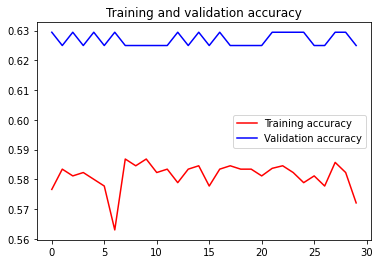

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()